# 到期日效应

## 摘要

## 理论模型

到期日效应(Expiration Day Effect)是指在股指期货合约临近交割时, 由于交易中的买卖失衡等原因而导致现货市场的交易量和价格波动性暂时扭曲的现象.

通常认为股指期货的到期日效应主要归因于市场中三种行为的存在:
* 指数套利(Index Arbitrage)
* 套期保值(Hedging): 机构投资者一般倾向于长期持有一定数量的股票组合, 为了防范系统性风险, 需要在期货市场上长期保持相应的空头仓位, 当一个股指期货合约到期时, 他们会将这一部位在到期日前平仓, 然后在其他合约上建立空头部位. 因此, 在临近合约到期日时, 会有大量要求平仓的买单出现.
* 资产组合保险(Portfolio Insurance)

股指期货到期日效应是通过比较到期日与非到期日中各项市场特性指标的差异来加以衡量的.

## 实证分析

In [1]:
# coding=utf-8
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline

import QuantStudio.api as QS

WDB = QS.FactorDB.WindDB2()

### 期现分析

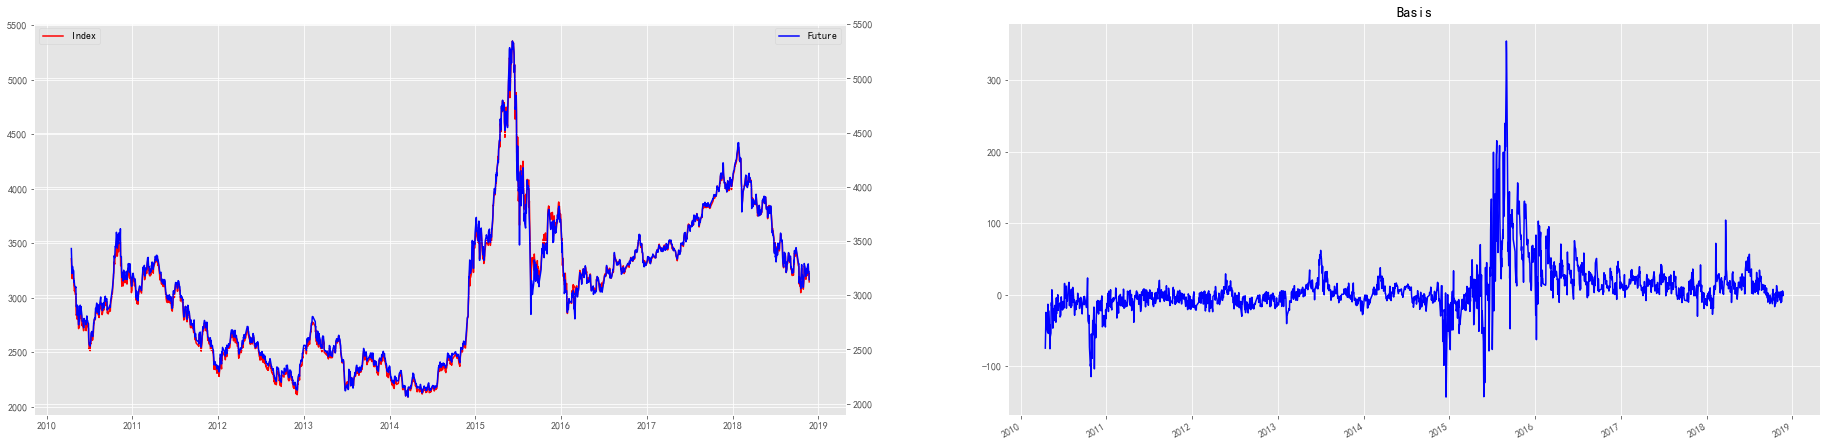

In [34]:
StartDT, EndDT = dt.datetime(2010,4,16), dt.datetime(2015,4,15)

WDB.connect()
FT = WDB.getTable("中国A股指数日行情")
DTs = FT.getDateTime(iid="000300.SH", start_dt=StartDT, end_dt=EndDT)
IndexPrice = FT.readData(factor_names=["收盘价(点)"], ids=["000300.SH"], dts=DTs).iloc[0,:,0]
FuturePrice = WDB.getTable("中国股指期货日行情").readData(factor_names=["结算价(元)"], ids=["IF.CFE"], dts=DTs).iloc[0,:,0]
WDB.disconnect()

# 基差
Basis = IndexPrice - FuturePrice

# 绘制价格和基差图像
Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
Axes[0].xaxis_date()
Axes[0].xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
Axes[0].plot(IndexPrice.index, IndexPrice.values, color='r', label="Index")
RAxis = Axes[0].twinx()
RAxis.plot(FuturePrice.index, FuturePrice.values, color='b', label="Future")
Axes[0].legend(loc='upper left')
RAxis.legend(loc='upper right')
Basis.plot(ax=Axes[1], color='b', title="Basis");

In [35]:
# --------平稳性检验--------
# 基差的 ADF 检验
BasisADFTest = sm.tsa.stattools.adfuller(Basis.values, regression='c', autolag="BIC")
print(("Basis ADF Test Statistic : %f" % BasisADFTest[0]), 
      ("pvalue : %f" % BasisADFTest[1]), 
      ("usedlag : %d" % BasisADFTest[2]), sep="\n")

Basis ADF Test Statistic : -3.884648
pvalue : 0.002151
usedlag : 17


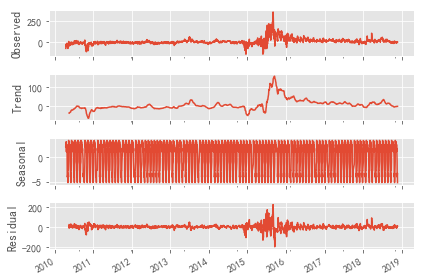

In [37]:
DecompositionResult = sm.tsa.seasonal_decompose(x=Basis, model='additive', freq=20, two_sided=False)
DecompositionResult.plot();

In [41]:
# 残差的 ADF 检验
ResidualADFTest = sm.tsa.stattools.adfuller(DecompositionResult.resid.dropna().values, regression='c', autolag="BIC")
print(("Residual ADF Test Statistic : %f" % ResidualADFTest[0]), 
      ("pvalue : %f" % ResidualADFTest[1]), 
      ("usedlag : %d" % ResidualADFTest[2]), sep="\n")

Residual ADF Test Statistic : -15.269227
pvalue : 0.000000
usedlag : 10


### 跨期分析

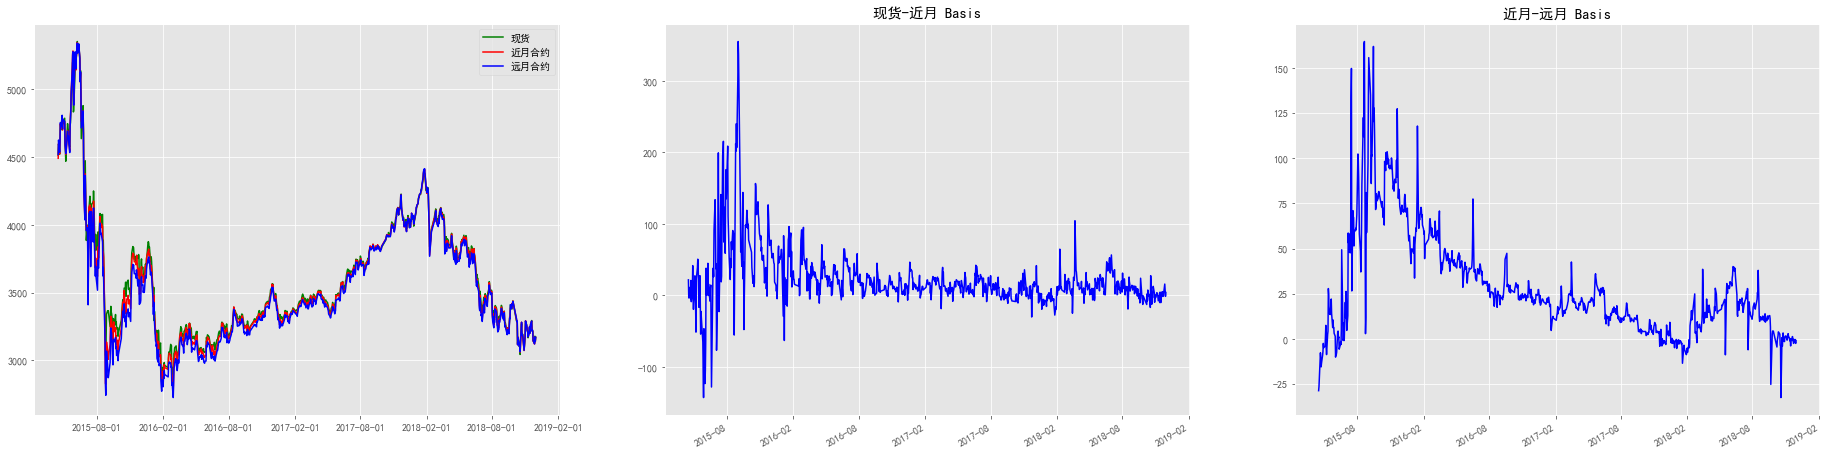

In [2]:
# StartDT, EndDT = dt.datetime(2010,4,16), dt.datetime(2013,4,16)
StartDT, EndDT = dt.datetime(2015,4,16), dt.datetime(2018,11,30)
IDs = ["IF00.CFE", "IF01.CFE"]# 当月合约, 下月合约
# IDs = ["IF.CFE", "IF_S.CFE"]# 主力合约, 次主力合约
WDB.connect()
FT = WDB.getTable("中国股指期货日行情")
DTs = FT.getDateTime(iid="IF.CFE", start_dt=StartDT, end_dt=EndDT)
IndexPrice = WDB.getTable("中国A股指数日行情").readData(factor_names=["收盘价(点)"], ids=["000300.SH"], dts=DTs).iloc[0,:,0]
FuturePrice = FT.readData(factor_names=["结算价(元)"], ids=IDs, dts=DTs).iloc[0,:,:]
FutureOI = FT.readData(factor_names=["持仓量(手)"], ids=IDs, dts=DTs).iloc[0,:,:]
ContractMapping = WDB.getTable("中国期货连续(主力)合约和月合约映射表").readData(factor_names=["映射月合约Wind代码"], ids=IDs, dts=DTs).iloc[0]
WDB.disconnect()

# 基差
SFBasis = IndexPrice - FuturePrice.iloc[:, 0]# 现货 - 近月合约
RFBasis = FuturePrice.iloc[:, 0] - FuturePrice.iloc[:, 1]# 近月合约 - 远月合约

# 近月合约到期位置
ContractEndPos = pd.Series(ContractMapping.iloc[:, 0].values!=np.r_[ContractMapping.iloc[1:, 0].values, np.array([None])], index=ContractMapping.index)

# 绘制价格和基差图像
Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].xaxis_date()
Axes[0].xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
Axes[0].plot(IndexPrice.index, IndexPrice.values, color='g', label="现货")
Axes[0].plot(FuturePrice.index, FuturePrice.iloc[:,0].values, color='r', label="近月合约")
Axes[0].plot(FuturePrice.index, FuturePrice.iloc[:,1].values, color='b', label="远月合约")
Axes[0].legend(loc='best')
SFBasis.plot(ax=Axes[1], color='b', title="现货-近月 Basis")
RFBasis.plot(ax=Axes[2], color='b', title="近月-远月 Basis");

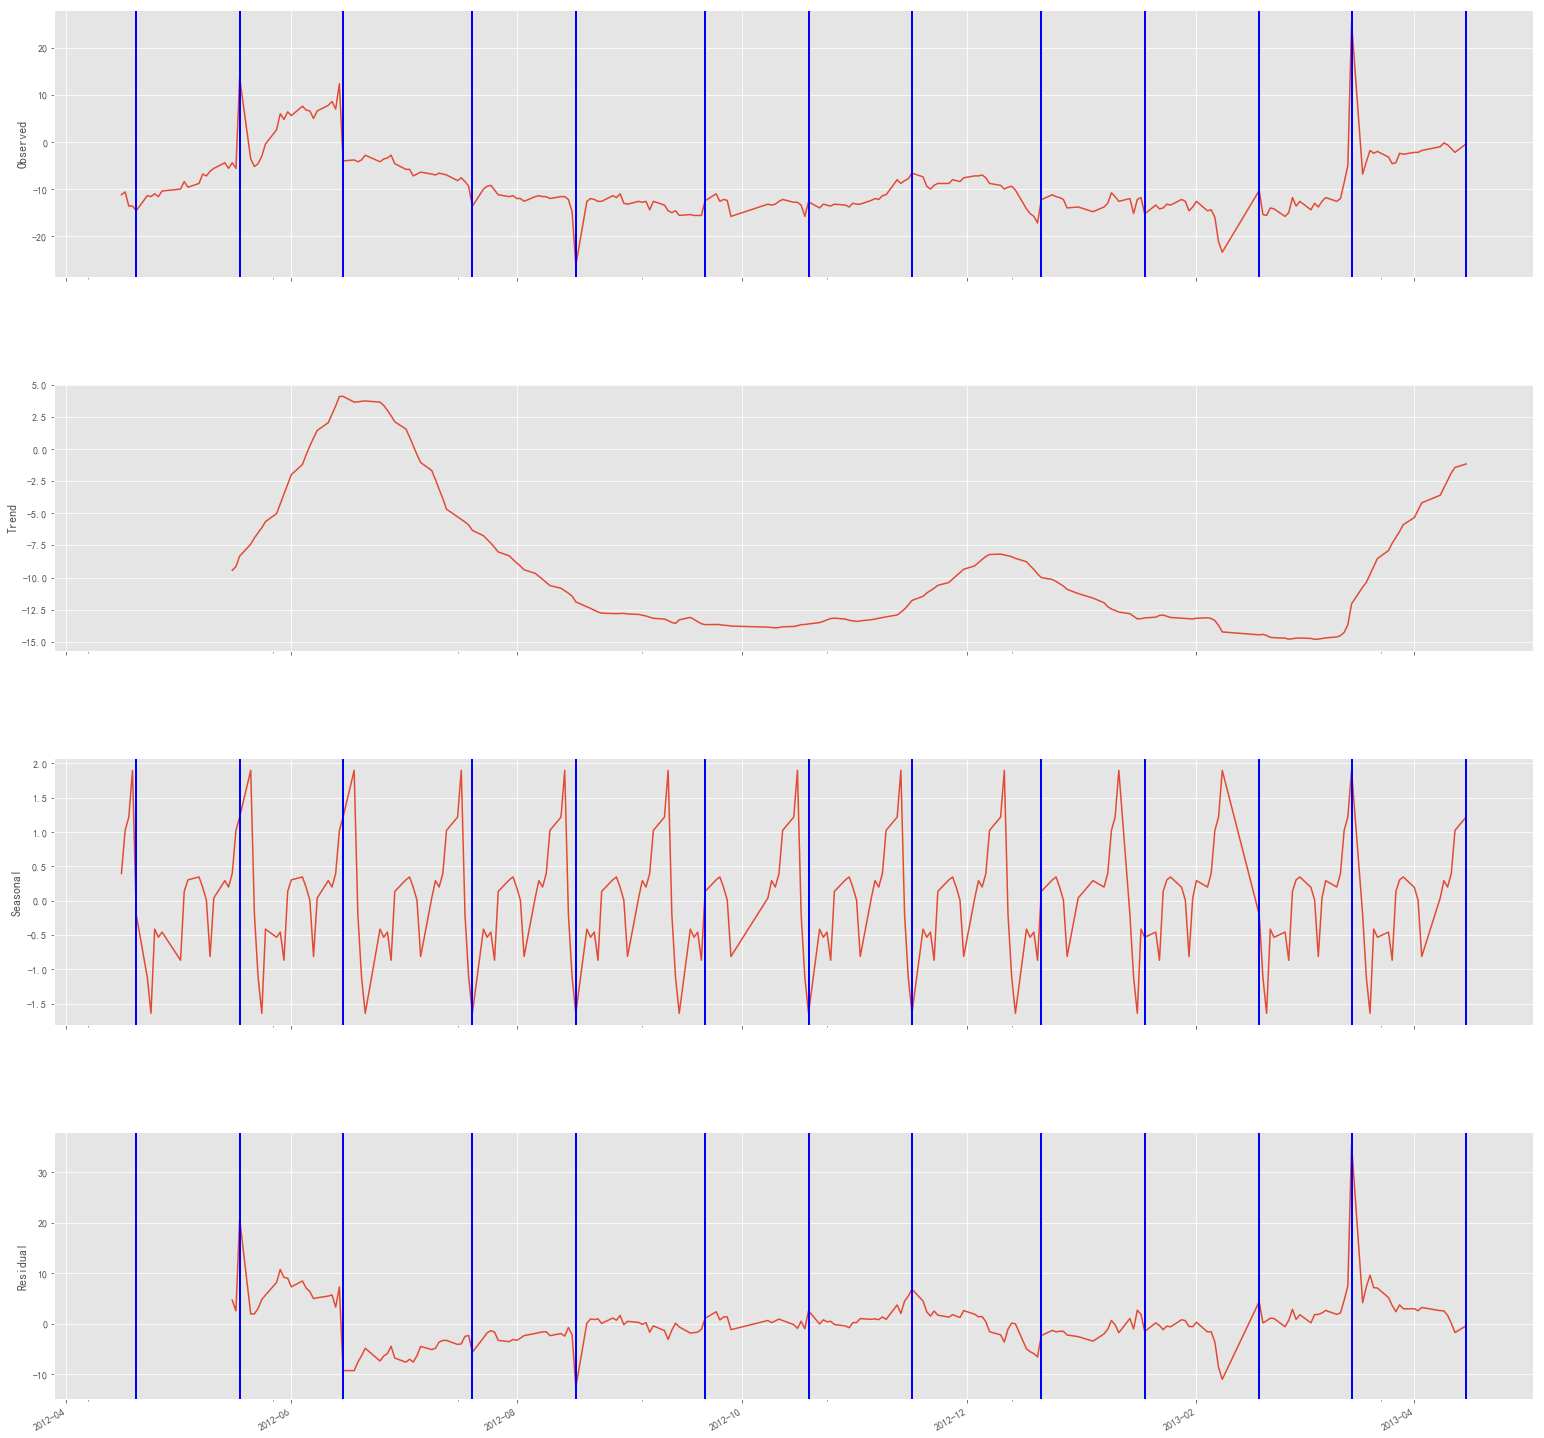

In [8]:
# --------平滑, 分解趋势和周期--------
# 指数平滑法(Holt-Winters Method)
DecompositionResult = sm.tsa.seasonal_decompose(x=RFBasis, model='additive', freq=20, two_sided=False)
Fig = DecompositionResult.plot()
Fig.set_size_inches(w=24, h=24, forward=True)
iAxes = Fig.axes[2]
for i in ContractEndPos[ContractEndPos].index:
    Fig.axes[0].axvline(i, color="b", linewidth=2)
    Fig.axes[2].axvline(i, color="b", linewidth=2)
    Fig.axes[3].axvline(i, color="b", linewidth=2)

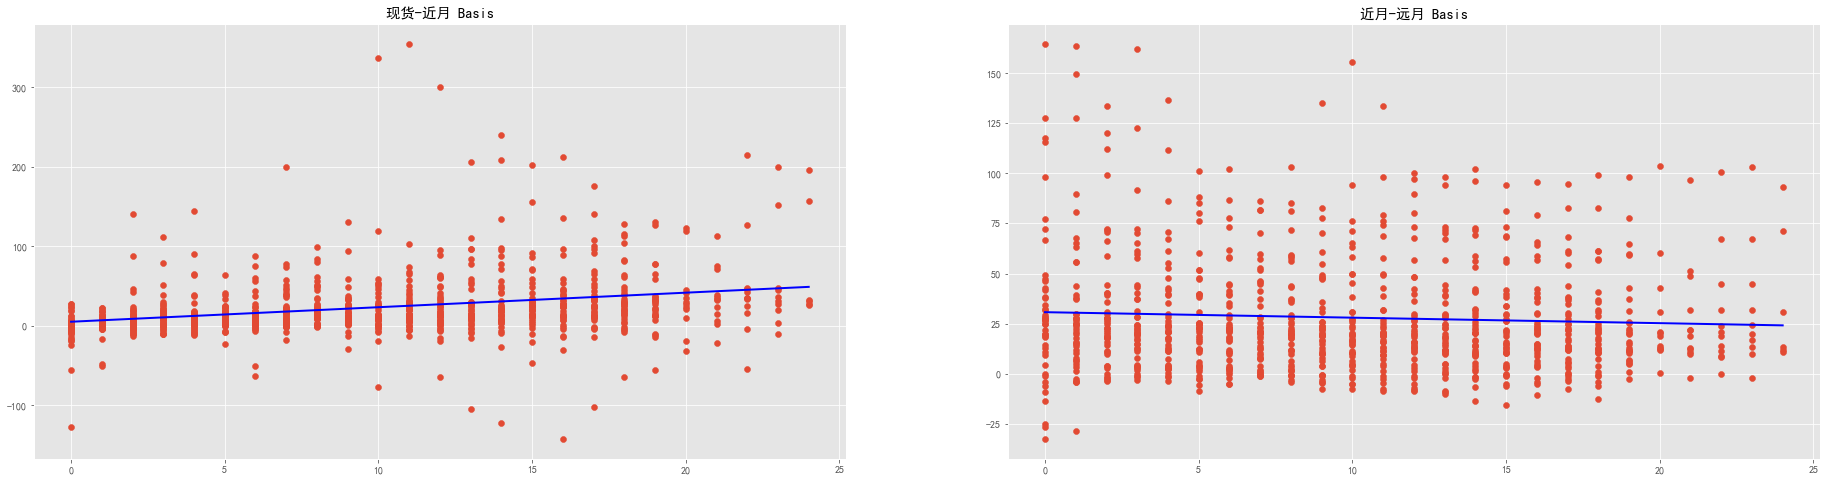

In [3]:
# --------基差和到期日的关系--------
Expiration = pd.Series(np.nan, index=ContractEndPos.index)
Expiration[ContractEndPos] = np.arange(ContractEndPos.shape[0])[ContractEndPos.values]
Expiration = Expiration.fillna(method="bfill") - np.arange(ContractEndPos.shape[0])
Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
Axes[0].scatter(Expiration.values, SFBasis.values)
Result = sm.OLS(SFBasis.values, sm.add_constant(Expiration.values, prepend=True), missing='drop').fit()
xData = np.sort(Expiration.values)
yRegressData = Result.params[0] + Result.params[1] * xData
Axes[0].plot(xData, yRegressData, label="回归线", color='b', linewidth=2)
Axes[0].set_title("现货-近月 Basis")

Axes[1].scatter(Expiration.values, RFBasis.values)
Result = sm.OLS(RFBasis.values, sm.add_constant(Expiration.values, prepend=True), missing='drop').fit()
yRegressData = Result.params[0] + Result.params[1] * xData
Axes[1].plot(xData, yRegressData, label="回归线", color='b', linewidth=2)
Axes[1].set_title("近月-远月 Basis");

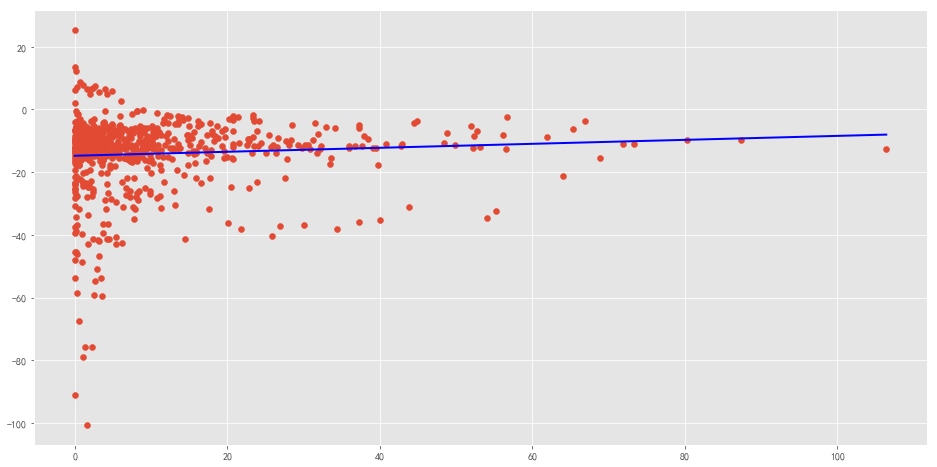

In [24]:
# --------基差和持仓比的关系--------
Fig, Axes = plt.subplots(1, 1, figsize=(16, 8))
xData = FutureOI.values[:, 0] / FutureOI.values[:, 1]
Axes.scatter(xData, Basis.values)
Result = sm.OLS(Basis.values, sm.add_constant(xData, prepend=True), missing='drop').fit()
xData = np.sort(xData)
yRegressData = Result.params[0] + Result.params[1] * xData
Axes.plot(xData, yRegressData, label="回归线", color='b', linewidth=2);

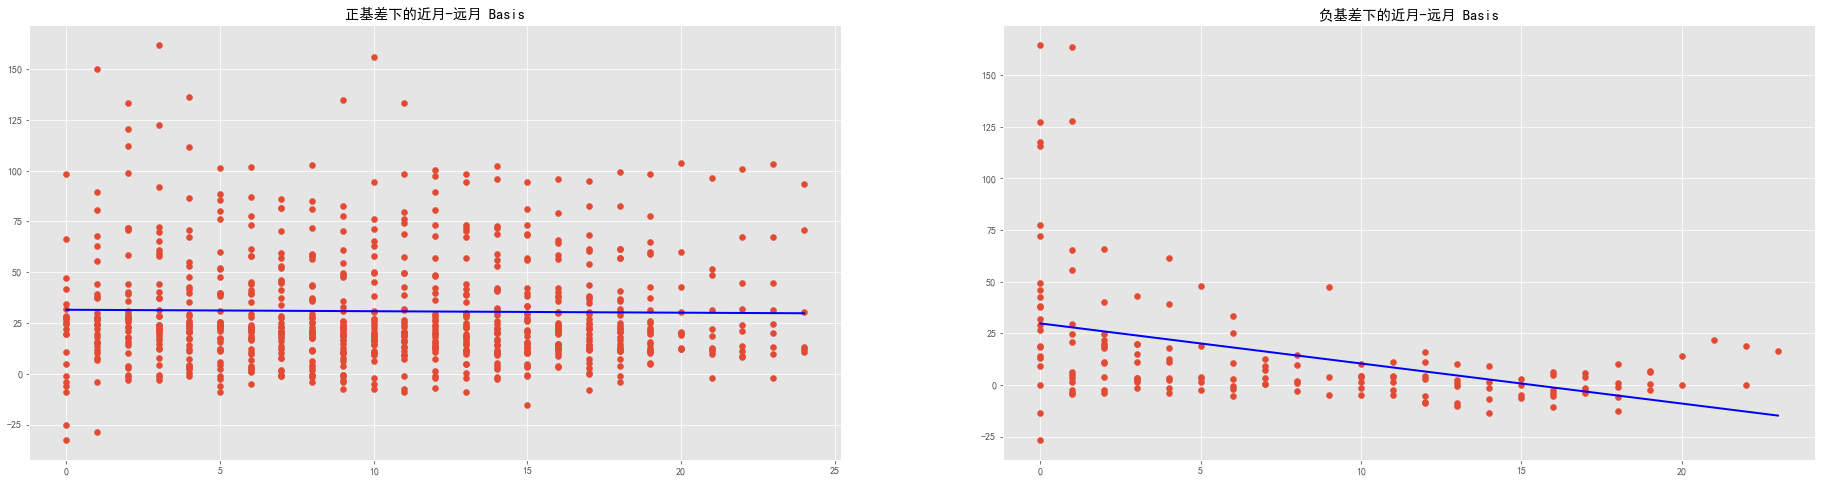

In [4]:
# --------正负基差和到期日的关系--------
PosSFBasisMask = (SFBasis>=0)
PosExpiration, PosRFBasis = Expiration[PosSFBasisMask], RFBasis[PosSFBasisMask]
NegSFBasisMask = (SFBasis<0)
NegExpiration, NegRFBasis = Expiration[NegSFBasisMask], RFBasis[NegSFBasisMask]
Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
Axes[0].scatter(PosExpiration.values, PosRFBasis.values)
Result = sm.OLS(PosRFBasis.values, sm.add_constant(PosExpiration.values, prepend=True), missing='drop').fit()
xData = np.sort(PosExpiration.values)
yRegressData = Result.params[0] + Result.params[1] * xData
Axes[0].plot(xData, yRegressData, label="回归线", color='b', linewidth=2)
Axes[0].set_title("正基差下的近月-远月 Basis")
Axes[1].scatter(NegExpiration.values, NegRFBasis.values)
Result = sm.OLS(NegRFBasis.values, sm.add_constant(NegExpiration.values, prepend=True), missing='drop').fit()
xData = np.sort(NegExpiration.values)
yRegressData = Result.params[0] + Result.params[1] * xData
Axes[1].plot(xData, yRegressData, label="回归线", color='b', linewidth=2)
Axes[1].set_title("负基差下的近月-远月 Basis");

In [5]:
# --------回归分析--------
# 近月-远月基差 = const + 到期时间
xData = sm.add_constant(Expiration.values, prepend=True)
Result = sm.OLS(RFBasis.values, xData, missing='drop').fit()
Result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.071
Date:                Mon, 24 Dec 2018   Prob (F-statistic):             0.0800
Time:                        14:55:01   Log-Likelihood:                -4249.2
No. Observations:                 888   AIC:                             8502.
Df Residuals:                     886   BIC:                             8512.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.7055      1.817     16.900      0.000      27.140      34.271
x1            -0.2742      0.156     -1.752      0.080      -0.581       0.033
==============================================================================
Omnibus:                      255.104   Durbin-Watson:                   0.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              636.013
Skew:                           1.508   Prob(JB):                    7.79e-139
Kurtosis:                       5.845   Cond. No.                         21.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# 近月-远月基差 = const + 到期时间 + 现货-近月基差
xData = np.c_[sm.add_constant(Expiration.values, prepend=True), SFBasis.values]
Result = sm.OLS(RFBasis.values, xData, missing='drop').fit()
Result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     229.8
Date:                Mon, 24 Dec 2018   Prob (F-statistic):           4.17e-81
Time:                        14:55:07   Log-Likelihood:                -4065.0
No. Observations:                 888   AIC:                             8136.
Df Residuals:                     885   BIC:                             8150.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.6280      1.481     19.335      0.000      25.722      31.534
x1            -1.0544      0.132     -7.964      0.000      -1.314      -0.795
x2             0.4267      0.020     21.330      0.000       0.387       0.466
==============================================================================
Omnibus:                      310.422   Durbin-Watson:                   0.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1883.999
Skew:                           1.459   Prob(JB):                         0.00
Kurtosis:                       9.512   Cond. No.                         89.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
# 近月-远月基差 = const + 到期时间 + lag(现货-近月基差, 1)
xData = np.c_[sm.add_constant(Expiration.values, prepend=True), np.r_[np.nan, SFBasis.values[0:-1]]]
Result = sm.OLS(RFBasis.values, xData, missing='drop').fit()
Result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     301.9
Date:                Mon, 24 Dec 2018   Prob (F-statistic):          1.14e-100
Time:                        14:55:22   Log-Likelihood:                -4013.6
No. Observations:                 887   AIC:                             8033.
Df Residuals:                     884   BIC:                             8048.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7439      1.420     18.133      0.000      22.958      28.530
x1            -0.8153      0.123     -6.643      0.000      -1.056      -0.574
x2             0.4531      0.019     24.457      0.000       0.417       0.489
==============================================================================
Omnibus:                      250.797   Durbin-Watson:                   0.437
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              888.617
Skew:                           1.326   Prob(JB):                    1.09e-193
Kurtosis:                       7.124   Cond. No.                         89.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# 近月-远月基差 = const + 到期时间 + lag(现货-近月基差, 1) + lag(近月持仓/远月持仓, 1)
xData = np.c_[sm.add_constant(Expiration.values, prepend=True),
              np.r_[np.nan, SFBasis.values[0:-1]],
              np.r_[np.nan, FutureOI.values[0:-1, 0] / FutureOI.values[0:-1, 1]]]
Result = sm.OLS(RFBasis.values, xData, missing='drop').fit()
Result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     207.8
Date:                Mon, 24 Dec 2018   Prob (F-statistic):          6.74e-102
Time:                        14:55:34   Log-Likelihood:                -3999.1
No. Observations:                 885   AIC:                             8006.
Df Residuals:                     881   BIC:                             8025.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.5645      1.414     18.081      0.000      22.790      28.339
x1            -0.6764      0.131     -5.169      0.000      -0.933      -0.420
x2             0.4534      0.018     24.595      0.000       0.417       0.490
x3            -0.0548      0.017     -3.260      0.001      -0.088      -0.022
==============================================================================
Omnibus:                      250.647   Durbin-Watson:                   0.430
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              910.673
Skew:                           1.319   Prob(JB):                    1.78e-198
Kurtosis:                       7.212   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# 近月-远月基差 = const + 到期时间 + lag(现货-近月基差, 1) + lag(log(近月持仓), 1)
xData = np.c_[sm.add_constant(Expiration.values, prepend=True),
              np.r_[np.nan, SFBasis.values[0:-1]],
              np.r_[np.nan, np.log(FutureOI.values[0:-1, 0]+1)]]
Result = sm.OLS(RFBasis.values, xData, missing='drop').fit()
Result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     218.0
Date:                Mon, 24 Dec 2018   Prob (F-statistic):          9.65e-106
Time:                        14:55:46   Log-Likelihood:                -3990.2
No. Observations:                 885   AIC:                             7988.
Df Residuals:                     881   BIC:                             8008.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.1626      3.873     11.660      0.000      37.560      52.765
x1            -1.0047      0.126     -8.005      0.000      -1.251      -0.758
x2             0.4764      0.019     25.449      0.000       0.440       0.513
x3            -1.8580      0.347     -5.362      0.000      -2.538      -1.178
==============================================================================
Omnibus:                      232.488   Durbin-Watson:                   0.433
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              817.761
Skew:                           1.230   Prob(JB):                    2.66e-178
Kurtosis:                       7.015   Cond. No.                         251.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

近月-远月基差 ADF Test Statistic : -2.023858
pvalue : 0.276211
usedlag : 8


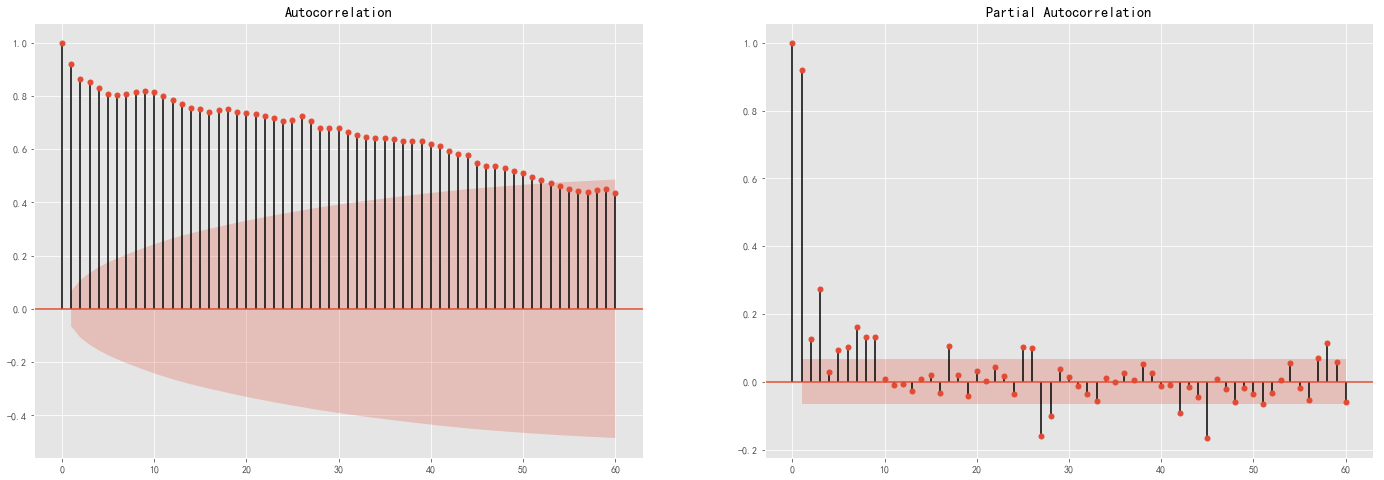

In [10]:
# --------平稳性检验--------
# 对数价格的 ADF 检验
RFBasisADFTest = sm.tsa.stattools.adfuller(RFBasis.values, regression='c', autolag="BIC")
print(("近月-远月基差 ADF Test Statistic : %f" % RFBasisADFTest[0]), 
      ("pvalue : %f" % RFBasisADFTest[1]), 
      ("usedlag : %d" % RFBasisADFTest[2]), sep="\n")

# ACF, PACF
Fig, Axes = plt.subplots(1, 2, figsize=(24, 8))
sm.graphics.tsa.plot_acf(RFBasis.values, lags=60, ax=Axes[0])
sm.graphics.tsa.plot_pacf(RFBasis.values, lags=60, ax=Axes[1]);

In [11]:
# --------ARMA 模型--------
# 确定 ARMA 模型的阶数
ARMAOrder = sm.tsa.stattools.arma_order_select_ic(RFBasis.values, max_ar=10, max_ma=3, ic="bic", trend='c')
ARMAOrder = ARMAOrder.bic_min_order
print(ARMAOrder)

(5, 2)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  886
Model:                     ARMA(1, 1)   Log Likelihood               -3328.835
Method:                       css-mle   S.D. of innovations             10.351
Date:                Mon, 24 Dec 2018   AIC                           6671.670
Time:                        15:04:16   BIC                           6705.177
Sample:                             0   HQIC                          6684.480
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.8372      6.842      4.945      0.000      20.426      47.248
x1            -0.6647      0.092     -7.228      0.000      -0.845      -0.484
x2             0.1244      0.014      8.899      0.0

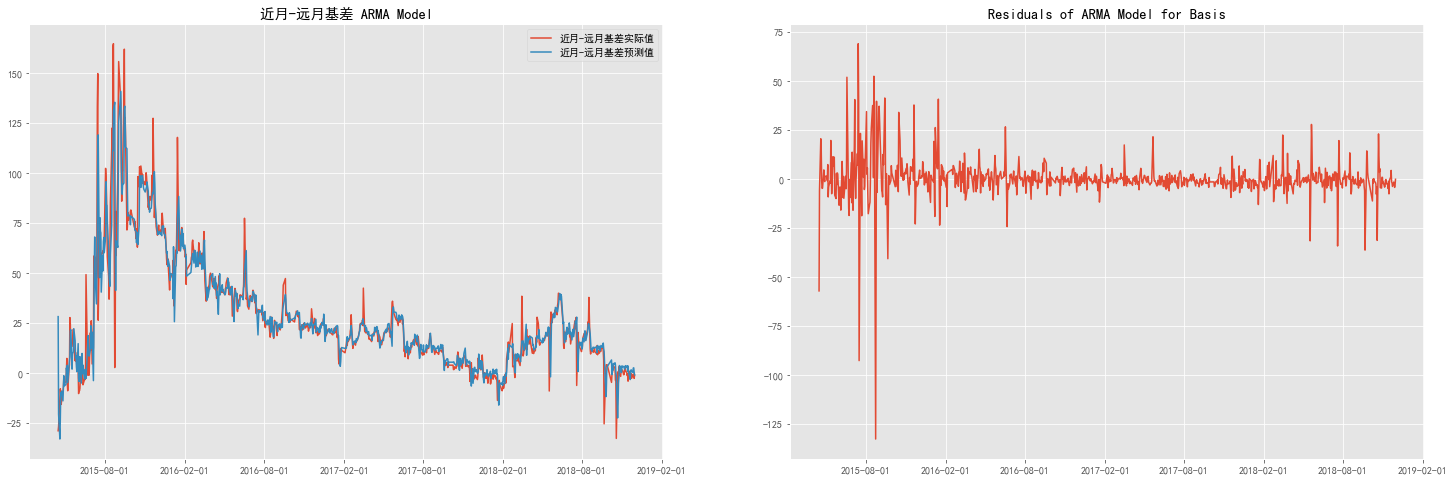

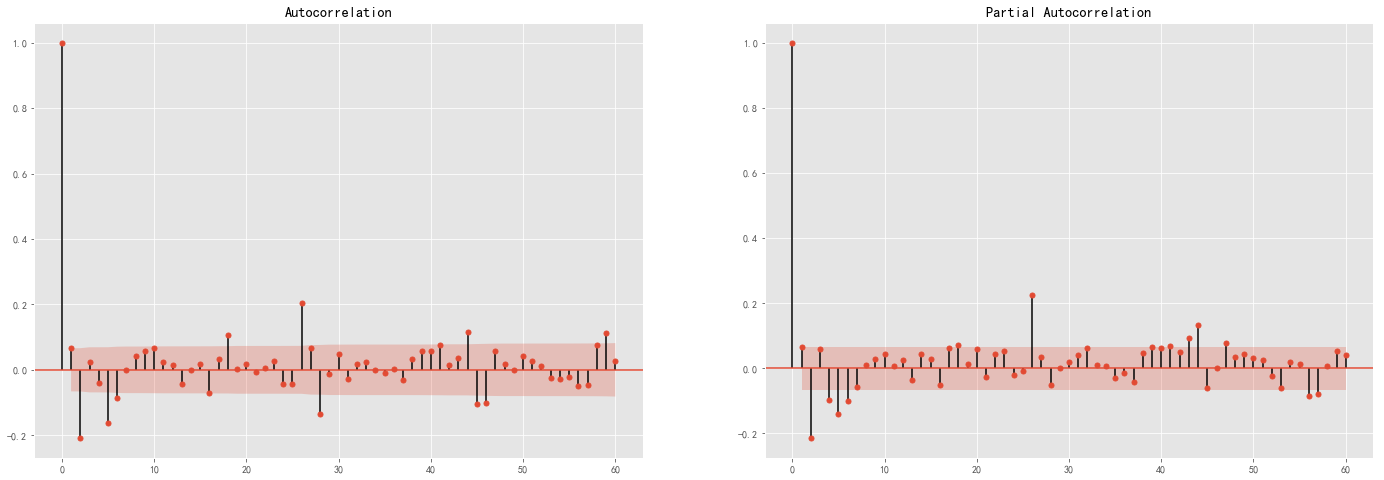

In [26]:
# --------ARMA 模型--------
# 构建 ARMA 模型
xData = np.c_[Expiration.values,
              np.r_[0.0, SFBasis.values[0:-1]],
              np.r_[np.log(FutureOI.values[0, 0]+1), np.log(FutureOI.values[0:-1, 0]+1)]]
NotNaMask = (~ ((np.sum(np.isnan(xData), axis=1)>0) | (np.isnan(RFBasis.values))))
ARMAModel = sm.tsa.ARMA(RFBasis.values[NotNaMask], exog=xData[NotNaMask, :], order=(1, 1))
ARMARslt = ARMAModel.fit(trend="c", disp=False)
print(ARMARslt.summary())

Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].xaxis_date()
Axes[0].xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
Axes[0].set_title("近月-远月基差 ARMA Model")
Axes[0].plot(RFBasis.index[NotNaMask], RFBasis.values[NotNaMask], label="近月-远月基差实际值")
Axes[0].plot(RFBasis.index[NotNaMask], ARMARslt.fittedvalues, label="近月-远月基差预测值")
Axes[0].legend()
Axes[1].xaxis_date()
Axes[1].xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
Axes[1].plot(RFBasis.index[NotNaMask], ARMARslt.resid)
Axes[1].set_title("Residuals of ARMA Model for Basis");

# 残差的 ACF, PACF
Fig, Axes = plt.subplots(1, 2, figsize=(24, 8))
sm.graphics.tsa.plot_acf(ARMARslt.resid, lags=60, ax=Axes[0])
sm.graphics.tsa.plot_pacf(ARMARslt.resid, lags=60, ax=Axes[1]);